# Assignment 4: Food, Halloween, and Analytics

In this assignment you will practice crawling to fetch data from a website (allrecipes.com).

You will then put your data into a Pandas dataframe and perform some analysis of the fetched recipes.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
!sudo pip3 install -U statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.9.0)
Requirement not upgraded as not directly required: pandas in /usr/local/lib/python3.6/dist-packages (from statsmodels) (0.23.0)
Requirement not upgraded as not directly required: patsy in /usr/local/lib/python3.6/dist-packages (from statsmodels) (0.5.0)
Requirement not upgraded as not directly required: numpy>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from pandas->statsmodels) (1.14.4)
Requirement not upgraded as not directly required: python-dateutil>=2.5.0 in /usr/local/lib/python3.6/dist-packages (from pandas->statsmodels) (2.7.3)
Requirement not upgraded as not directly required: pytz>=2011k in /usr/local/lib/python3.6/dist-packages (from pandas->statsmodels) (2018.4)
Requirement not upgraded as not directly required: six in /usr/lib/python3/dist-packages (from patsy->statsmodels) (1.11.0)
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgra

In [3]:
from lxml import html
from xml.etree import ElementTree
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import statsmodels.formula.api as smf
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

## Task 1: Crawl AllRecipes.com

We are getting ready for Halloween, and we want to cook some good food. No, good is not good enough. We want to first the BEST recipe for Heloween.

But to find the best recipe, we need data. 

After a 1-min Google search, we find the page `https://www.allrecipes.com/recipes/189/holidays-and-events/halloween/` that contains recipes for Halloween. From a quick look on the webpage, we see that, for each recipe we have a **star rating**, and we also have the **number of reviews** for the recipe.

So, you need to write a crawler that will parse AllRecipes and fetch data for the recipes. For this assignment, we will only fetch the data from the recipes from the results page; we will not fetch the recipes themselves.  We need to fetch the title of the recipe, the URL for the recipe, the number of reviews, and the average star rating (out of 5 stars).

Tips:

* The URLs for the pages with the recipes have the form `https://www.allrecipes.com/recipes/189/holidays-and-events/halloween/?page=...` with the page parameter taking values from 1 and above.
* Each recipe entry is stored under HTML nodes marked as `<article @class="fixed-recipe-card">`. You need to parse these nodes to get the information for each recipe.
* To get the number of reviews, you may need to take a look at the HTML source using the "View Source" capability. The "developer view" hides the fact that the number is not text but part of an HTML tag (e.g., the number 2004 will be listed as `<format-large-number number="2004"></format-large-number>`)

In [4]:
# Template code to get you started. This code gets as input an HTML page and extracts the list
# of recipes that are listed there.

def get_recipes_from_page(url):
    doc = html.fromstring(requests.get(url).text)
    recipes = doc.xpath("//article[@class='fixed-recipe-card']")

    result = []
    for r in recipes:
        
        # DEBUGING CODE. Use it to print out the HTML of the "recipe card"
        # html_str = ElementTree.tostring(r).decode()
        # print(html_str)
        # print("=============================\n=============================\n=============================")
        # continue
        
        ### WRITE YOUR CODE HERE. 
        # Your XPath queries should identify the corresponding parts of the page 
        # that contain the information that you need. 
        title = r.xpath(".//span[@class='fixed-recipe-card__title-link']")[0].text_content()
        recipe_url = r.xpath(".//a")[0].get("href") 
        rating = float(r.xpath(".//span/@data-ratingstars")[0].strip())#/div[2]/a/div[1]/span[1].//span/@data-ratingstars
        reviews = r.xpath(".//span/format-large-number/@number")[0] #/div[2]/a/div[1]/span[2]
        
        # If you feel adventurous: write a crawler that connects to the 
        # main page of the recipe, and fetched the calories
        # calories = get_calories(recipe_url)
        
        entry = {
            'title' : title,
            'recipe_url' : recipe_url,
            'rating' : round(float(rating),2),
            'reviews' : int(reviews),
            #'calories' : get_calories(url)
        }
        result.append(entry)
        
    return result

In [5]:
test_url = 'https://www.allrecipes.com/recipes/189/holidays-and-events/halloween/?page=1'
get_recipes_from_page(test_url)

[{'rating': 5.0,
  'recipe_url': 'https://www.allrecipes.com/recipe/234308/broomstick-dip/',
  'reviews': 3,
  'title': 'Broomstick Dip'},
 {'rating': 4.45,
  'recipe_url': 'https://www.allrecipes.com/recipe/13768/roasted-pumpkin-seeds/',
  'reviews': 534,
  'title': 'Roasted Pumpkin Seeds'},
 {'rating': 4.26,
  'recipe_url': 'https://www.allrecipes.com/recipe/67656/cake-balls/',
  'reviews': 1871,
  'title': 'Cake Balls'},
 {'rating': 4.68,
  'recipe_url': 'https://www.allrecipes.com/recipe/240007/peanut-butter-spider-cookies/',
  'reviews': 21,
  'title': 'Peanut Butter Spider Cookies'},
 {'rating': 4.71,
  'recipe_url': 'https://www.allrecipes.com/recipe/128644/halloween-bloody-baked-rats/',
  'reviews': 92,
  'title': 'Halloween Bloody Baked Rats'},
 {'rating': 4.34,
  'recipe_url': 'https://www.allrecipes.com/recipe/21468/witches-brew/',
  'reviews': 94,
  'title': "Witches' Brew"},
 {'rating': 4.77,
  'recipe_url': 'https://www.allrecipes.com/recipe/219206/halloween-fruit-apple-t

In [6]:
# This code will go through the first 50 pages of the results, extracting recipes
# Once a page returns back 0 recipes, we stop

# We store our results in this list
allrecipes = []
for page in range(1,50):
    url = 'https://www.allrecipes.com/recipes/189/holidays-and-events/halloween/?page=' + str(page)
    # We get back a list of dictionaries for each page; each dictionary corresponds to a recipe
    recipes = get_recipes_from_page(url)
    print(f"Found {len(recipes)} recipes in page {page}")
    if len(recipes) == 0:
        break
    allrecipes.extend(recipes)
    
print(f"We extracted a total of {len(allrecipes)} recipes")

Found 28 recipes in page 1
Found 20 recipes in page 2
Found 20 recipes in page 3
Found 20 recipes in page 4
Found 20 recipes in page 5
Found 20 recipes in page 6
Found 20 recipes in page 7
Found 20 recipes in page 8
Found 20 recipes in page 9
Found 20 recipes in page 10
Found 20 recipes in page 11
Found 20 recipes in page 12
Found 20 recipes in page 13
Found 20 recipes in page 14
Found 20 recipes in page 15
Found 20 recipes in page 16
Found 20 recipes in page 17
Found 20 recipes in page 18
Found 20 recipes in page 19
Found 20 recipes in page 20
Found 20 recipes in page 21
Found 20 recipes in page 22
Found 20 recipes in page 23
Found 20 recipes in page 24
Found 20 recipes in page 25
Found 20 recipes in page 26
Found 20 recipes in page 27
Found 20 recipes in page 28
Found 20 recipes in page 29
Found 20 recipes in page 30
Found 20 recipes in page 31
Found 3 recipes in page 32
Found 0 recipes in page 33
We extracted a total of 631 recipes


In [7]:
# Create a dataframe with the recipes
df = pd.DataFrame(allrecipes)
df

,rating,recipe_url,reviews,title
0,5.00,https://www.allrecipes.com/recipe/234308/broom...,3,Broomstick Dip
1,4.45,https://www.allrecipes.com/recipe/13768/roaste...,534,Roasted Pumpkin Seeds
2,4.26,https://www.allrecipes.com/recipe/67656/cake-b...,1871,Cake Balls
3,4.68,https://www.allrecipes.com/recipe/240007/peanu...,21,Peanut Butter Spider Cookies
4,4.71,https://www.allrecipes.com/recipe/128644/hallo...,92,Halloween Bloody Baked Rats
5,4.34,https://www.allrecipes.com/recipe/21468/witche...,94,Witches' Brew
6,4.77,https://www.allrecipes.com/recipe/219206/hallo...,26,Halloween Fruit Apple Teeth Treats
7,4.50,https://www.allrecipes.com/recipe/228246/witch...,37,Witches' Hats
8,4.38,https://www.allrecipes.com/recipe/216230/blood...,72,Bloody Broken Glass Cupcakes
9,4.43,https://www.allrecipes.com/recipe/10402/the-be...,7937,The Best Rolled Sugar Cookies


## Task 2: Descriptive Statistics on Recipes

We now start analyzing the recipes. 

a. Use the `describe()` and `hist()` commands to analyze the contents of the `reviews` and `rating` columns.

b. Find the recipe with the highest number of reviews

c. Based on the results of the first exploratory analysis, you decide to keep only recipes more than 10 reviews, and with rating above 4.5. Create a new dataframe with only these well-reviewed, and highly-rated recipes.

d. Among the recipes with more than 10 reviews, find the one with the highest rating. The command `df.rating.max()` returns back the highest value for the column `rating` of the dataframe `df`.

e. Find all the recipes with more than 10 reviews, and with rating above 4.5, that contain the word 'Cookie' in the title. The command `df.title.str.contains('Cookie')` can be used for this purpose.

f. Using the dataframe from step (c), create a scatterplot that shows the number of reviews on the x-axis and the recipe rating on the y axis.

g. Use `statsmodels` and run an OLS regression examining if there is a correlation between the number of reviews and the recipe rating. The code below takes as input a dataframe `df` and runs a regression of column `Y` against columns `X1` and `X2`.

```python
results = smf.ols('Y ~ X1 + X2', data=df).fit()
print(results.summary())
```

Examine the returned coefficients and explain if there is a statistically significant effect. 


h. (**Very Hard**; optional) Find the Pareto-optimal set of recipes. A recipe belongs to the Pareto-optimal set if there is no other recipe that dominates it. We say that a recipe A dominates recipe B if `(A.rating >= B.rating and A.reviews >= B.reviews)`. Do the same for recipes that contain the word `Cookie`.

Description of reviews: 
 count     631.000000
mean       97.451664
std       438.026948
min         0.000000
25%         3.000000
50%        12.000000
75%        50.500000
max      7937.000000
Name: reviews, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


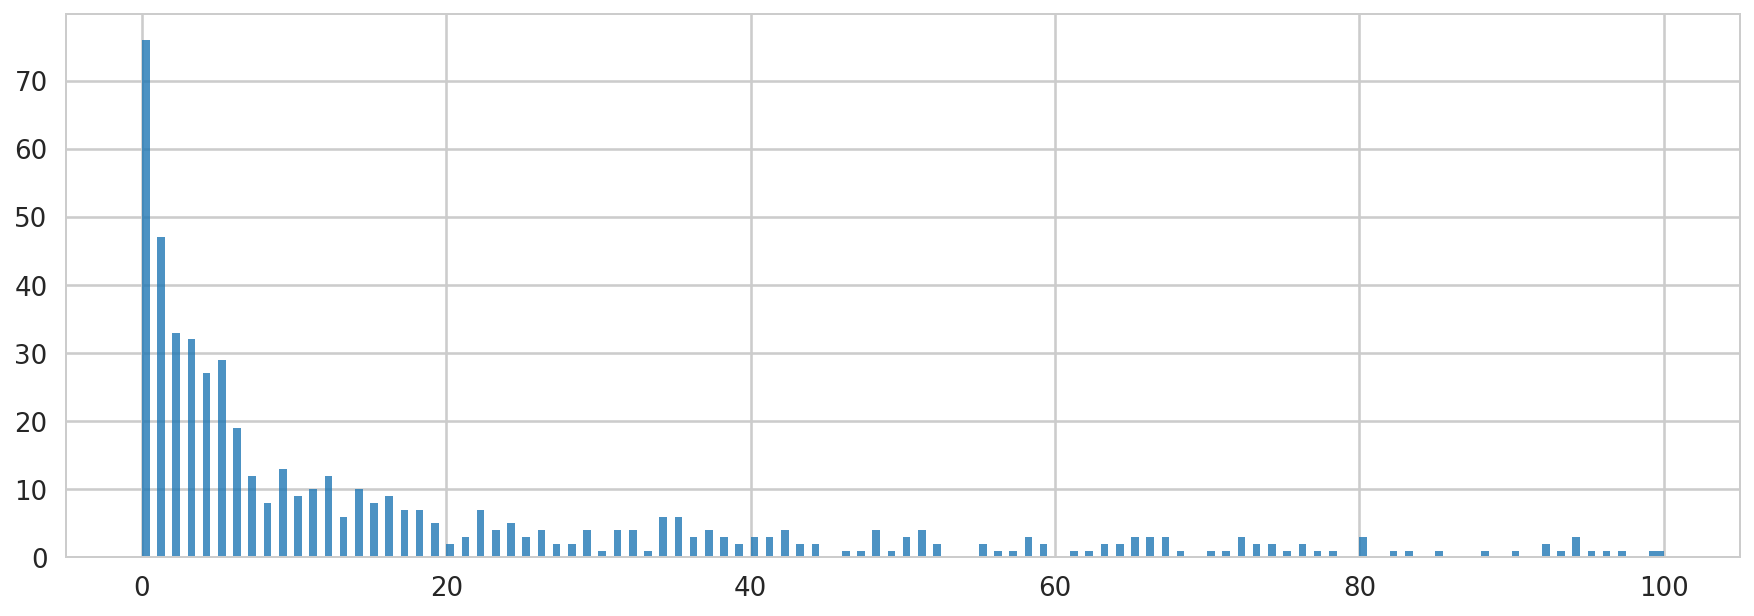

In [8]:
#Part A
print("Description of reviews:",'\n',df.reviews.describe())
print(df.reviews.hist(bins=200, # use 200 bars
                          range=(0,100), # x-axis from 0 to 100
                          density=False,  # show normalized count (density=True), or raw counts (density= False)
                          figsize=(15,5), # controls the size of the plot
                          alpha = 0.8 # make the plot 20% transparent
                         ))

Description of ratings: 
 count    631.000000
mean       3.902044
std        1.429675
min        0.000000
25%        4.000000
50%        4.430000
75%        4.670000
max        5.000000
Name: rating, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


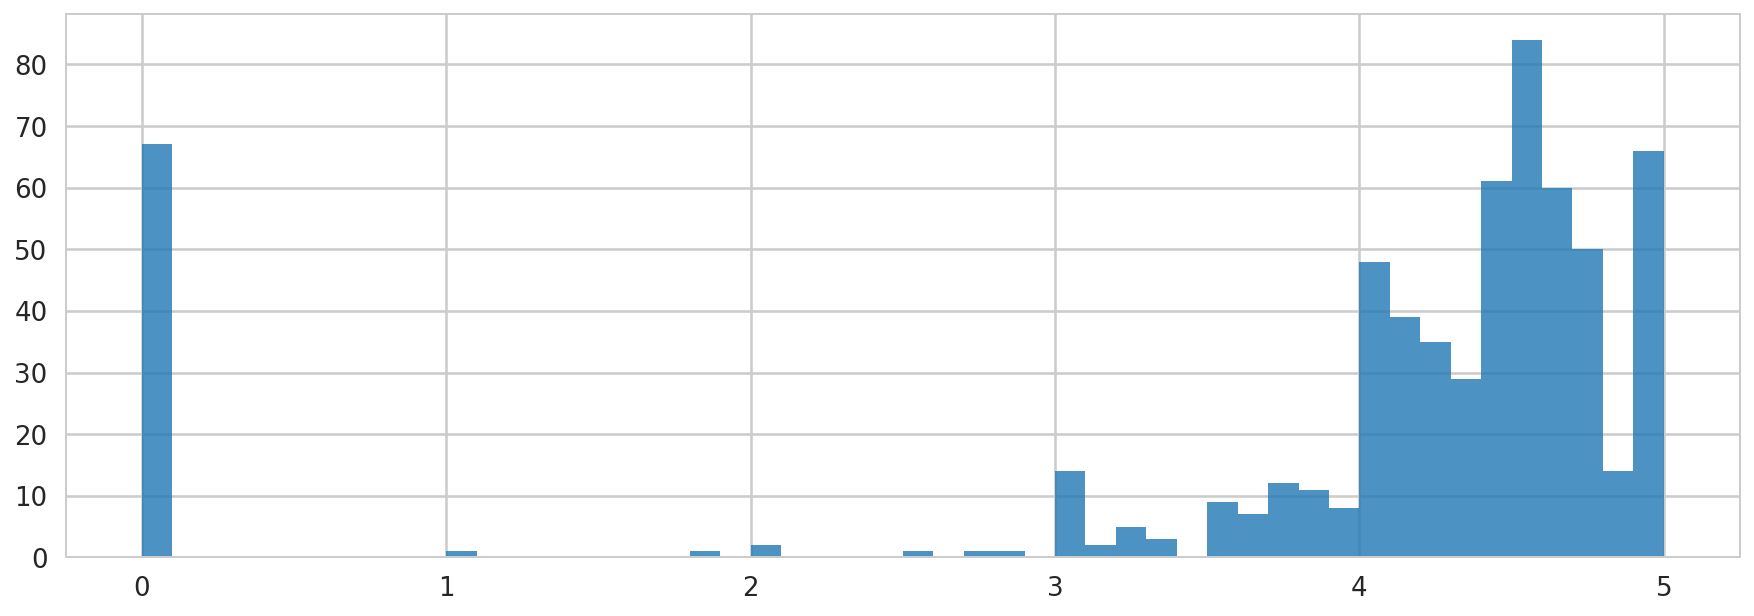

In [9]:
print("Description of ratings:",'\n',df.rating.describe())
print(df.rating.hist(bins=50,
                    range=(0,5),
                    density=False,
                    figsize=(15,5),
                    alpha=0.8
                    ))

In [19]:
#Part B
#df[df.reviews == df.reviews.max()] # first attempt
#df.loc[df.reviews.idxmax()] # second attempt
max_row = np.argmax(df.reviews.values)
df.title.values[max_row]


'The Best Rolled Sugar Cookies'

In [11]:
#Part C
best_reviews = df.loc[(df.rating > 4.5) & (df.reviews > 10)]
df2 = pd.DataFrame(best_reviews)
df2

,rating,recipe_url,reviews,title
3,4.68,https://www.allrecipes.com/recipe/240007/peanu...,21,Peanut Butter Spider Cookies
4,4.71,https://www.allrecipes.com/recipe/128644/hallo...,92,Halloween Bloody Baked Rats
6,4.77,https://www.allrecipes.com/recipe/219206/hallo...,26,Halloween Fruit Apple Teeth Treats
10,4.66,https://www.allrecipes.com/recipe/24264/sloppy...,4948,Sloppy Joes II
11,4.72,https://www.allrecipes.com/recipe/10033/iced-p...,3266,Iced Pumpkin Cookies
12,4.67,https://www.allrecipes.com/recipe/23439/perfec...,2019,Perfect Pumpkin Pie
13,4.76,https://www.allrecipes.com/recipe/8372/black-m...,2173,Black Magic Cake
14,4.55,https://www.allrecipes.com/recipe/10740/pumpki...,1298,Pumpkin Chocolate Chip Cookies III
15,4.72,https://www.allrecipes.com/recipe/11646/pauls-...,1058,Paul's Pumpkin Bars
16,4.68,https://www.allrecipes.com/recipe/26740/chocol...,1068,Chocolate Chip Cheese Ball


In [12]:
#Part D
df2[df2.rating == df2.rating.max()] 
#max_row = np.argmax(df2.rating.values)
#df2.title.values[max_row]  # there are two recipes with the highest rating the commented code only displays
                            # the Broiler S'mores


,rating,recipe_url,reviews,title
190,4.96,https://www.allrecipes.com/recipe/143055/broil...,35,Broiler S'mores
252,4.96,https://www.allrecipes.com/recipe/244234/hallo...,23,Halloween Zombie Meatloaf


In [13]:
#Part E
df2.loc[df2.title.str.contains('Cookie')]

,rating,recipe_url,reviews,title
3,4.68,https://www.allrecipes.com/recipe/240007/peanu...,21,Peanut Butter Spider Cookies
11,4.72,https://www.allrecipes.com/recipe/10033/iced-p...,3266,Iced Pumpkin Cookies
14,4.55,https://www.allrecipes.com/recipe/10740/pumpki...,1298,Pumpkin Chocolate Chip Cookies III
32,4.58,https://www.allrecipes.com/recipe/10949/pumpki...,491,Pumpkin Cookies V
57,4.55,https://www.allrecipes.com/recipe/11618/pumpki...,218,Pumpkin Cookies I
86,4.67,https://www.allrecipes.com/recipe/228740/pumpk...,141,Pumpkin Oatmeal Chocolate Chip Cookies
87,4.55,https://www.allrecipes.com/recipe/11288/egg-fr...,132,Egg Free Chocolate Chip Pumpkin Cookies
98,4.70,https://www.allrecipes.com/recipe/10385/pumpki...,113,Pumpkin Cookies with Penuche Frosting
109,4.68,https://www.allrecipes.com/recipe/10671/pumpki...,93,Pumpkin Cookies III
112,4.58,https://www.allrecipes.com/recipe/229108/pumpk...,85,Pumpkin Cookies with Cream Cheese Frosting (Th...


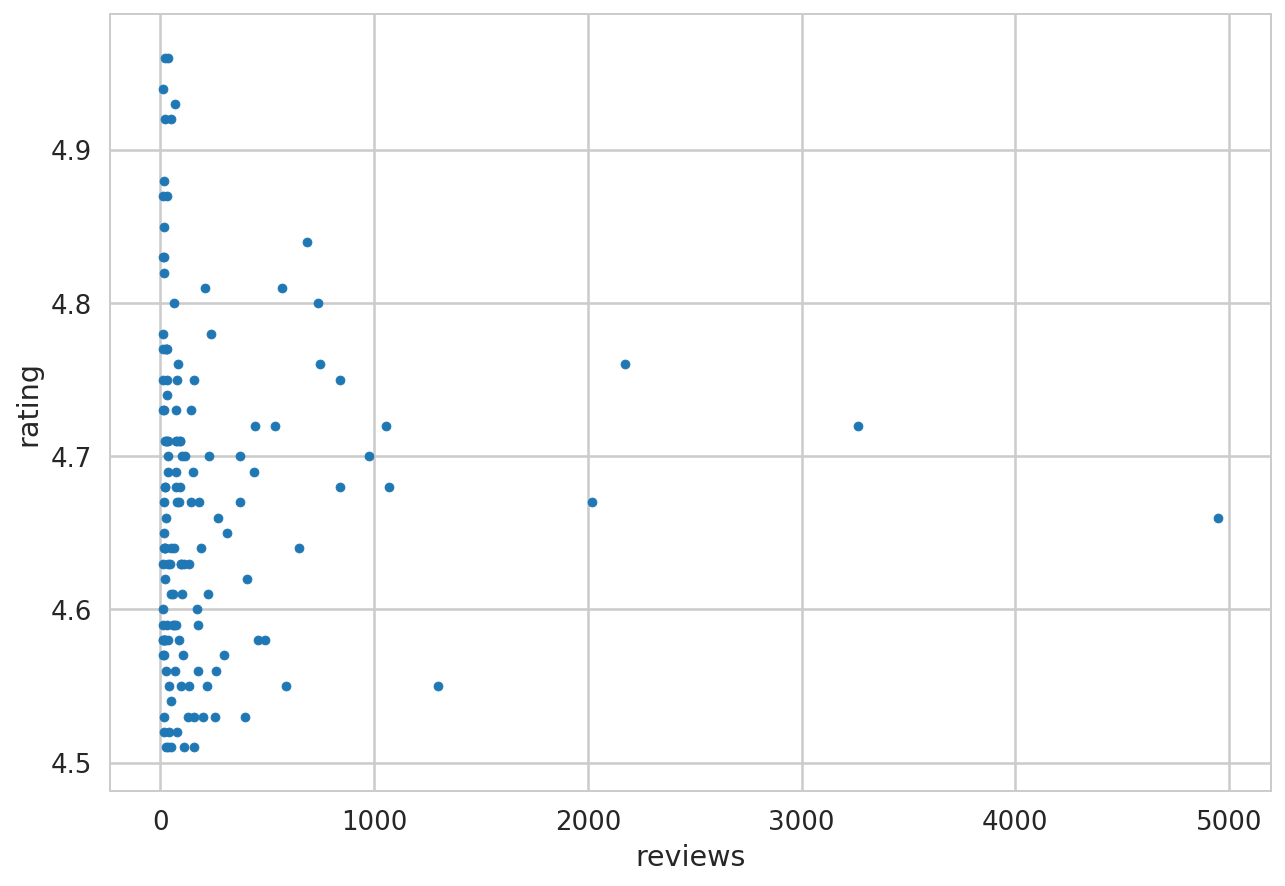

In [14]:
#Part F
df2.plot(kind='scatter', x='reviews', y='rating')

In [15]:
#Part G
X1 = df.reviews 
Y = df.rating
results = smf.ols('Y ~ X1', data=df).fit()
print(results.summary())
# The coeifficent for X1, reviews, is extremely low, so this means there is a weak relationship between
#the number of reviews and the rating
#The coefficient indicates that for every additional review
#you can expect the rating to increase by an average of 0.0003 or 0

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.233
Date:                Sun, 04 Nov 2018   Prob (F-statistic):             0.0128
Time:                        17:23:54   Log-Likelihood:                -1117.3
No. Observations:                 631   AIC:                             2239.
Df Residuals:                     629   BIC:                             2247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8705      0.058     66.656      0.0

In [16]:
X1 = df2.reviews 
Y = df2.rating
results = smf.ols('Y ~ X1', data=df2).fit()
print(results.summary())
#The coeifficent for X1, reviews, is high so this means there is a relationship between
#the number of reviews and the rating, however the R-squared is low. 
#The coefficient indicates that for every additional review
#you can expect the rating to increase by an average of 7.11

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1410
Date:                Sun, 04 Nov 2018   Prob (F-statistic):              0.708
Time:                        17:23:54   Log-Likelihood:                 118.41
No. Observations:                 143   AIC:                            -232.8
Df Residuals:                     141   BIC:                            -226.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6679      0.010    481.488      0.0